## Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Change here the path in witch is present the project data
%cd /content/drive/MyDrive/AIC/Project/

/content/drive/MyDrive/AIC/Project


## Requirements

Run the following block to install the needed dependencies.


In [ ]:
!pip install -q tensorflow==2.0.0
!pip install -q adversarial-robustness-toolbox[all]
!pip install -q h5py==2.10.0
!pip install -q git+https://github.com/JanderHungrige/tf.keras-vggface
!pip install -q Pillow


In [4]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import art
from art import config
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent
import ast
from collections import OrderedDict
import cv2
import dlib
from google.colab.patches import cv2_imshow
%matplotlib inline
from keras_vggface_TF.vggfaceTF import VGGFace
from keras_vggface_TF import utils
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd  
import pickle as pk
import PIL
import statistics
from sklearn import svm, metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam 
import pickle
import random

if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

## Data splitting


To download and extract the dataset and the label you can run the following 
block.

In [ ]:
# This is commented to avoid to re-download the data. Untar require a lot
    # of time.
!gdown --id 1SXhc8m5PHxyM4lEWVEccSufIa8OiOjGW
!gdown --id 1K47RjWJ-BYSMEw8V7U6FM2QUp3CO51M1
!tar -xzvf "./vggface2_test.tar.gz" 
!mkdir ./dataset/
!mv ./test/* ./dataset/
!rm -r ./test/
!rm ./vggface2_test.tar.gz

Our dataset is located in a folder, divided in subfolder by identity. We enumerate all the images with the associated identity and split just the 
enumeration, to not move files or create copy.

In [ ]:
def get_db_info(path):
  """Returns a python dict where the key represents the face id and the value 
  the list of files. The folder pointed by path is structured as follows:
      
    path
      |- id1
      |   |- file1.jpg
      |   |- file2.jpg
      |- id2
          |- file1.jpg
          |- file2.jpg

  Args:
    path(str): The starting path for search

  Returns:
    db(Dict[str,List[str]]): The object described below.
  """
  files = os.listdir(path)
  identities = files
  db = {}
  for id in identities:
    tmp_dir = os.listdir(os.path.join(path, id))
    if tmp_dir:
      db[id] = tmp_dir

  return db

Compute dome statistics on the data, to understand how to split the data and how to use that.

In [ ]:
db = get_db_info(os.path.join('.', 'dataset'))

print(f'# Identitys: {len(db.keys())}')
print(f'Max samples number is {np.max([len(db[id]) for id in db.keys()])} for identity {list(db.keys())[np.argmax([len(db[id]) for id in db.keys()])]}')
print(f'Average number of samples is {np.sum([len(db[id]) for id in db.keys()])/len(db)}')
print(f'Min samples number is {np.min([len(db[id]) for id in db.keys()])} for identity {list(db.keys())[np.argmin([len(db[id]) for id in db.keys()])]}')
print()
print(f'To have all the other class in the negative class you can have {np.max([len(db[id]) for id in db.keys()])/(len(db.keys())-1)} samples for each class.')

# Identitys: 156
Max samples number is 641 for identity n003217
Average number of samples is 338.55128205128204
Min samples number is 45 for identity n003490

To have all the other class in the negative class you can have 4.135483870967742 samples for each class.


Understood that, we considered to use as target class the Class with the greatest number of samples. For the 'other' class we considered to add samples from all other identity, triing to leave the dataset balanced.

In [ ]:
# Fix seed to make all the run as the same
random.seed(34)

# Get the file enumeration
# db = get_db_info(os.path.join('.', 'dataset'))
target_id = 'n003217'

samples = pd.DataFrame(columns=['file_path', 'id', 'real_class'])

# For each identity
for id in db:
  # We get the file list
  files = db[id]
  # We shuffle that to have a random selection
  random.shuffle(files)
  if id == target_id:
    # If the class is the target class, we add all the samples to the dataset.
    for f in files:
      samples = samples.append(dict(file_path=os.path.join('.', 'dataset', id, f), id=1, real_class=id), ignore_index=True)
    # Otherwise, we consider just 5 samples,
  else:
    for i in range(5):
      samples = samples.append(dict(file_path=os.path.join('.', 'dataset', id, files[i]), id=0, real_class=id), ignore_index=True)

# Finally, we save the enumeration on a csv.
samples.to_csv(os.path.join('.', 'data', 'images.csv'), index=False)


## Face Detection, Crop, and Alignment

In this section we want implement a scheme link in the following figure.
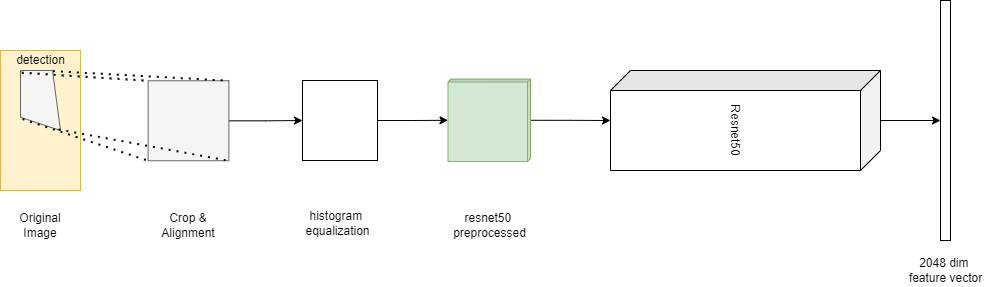

This part use a NN to find 68 facial landmarks. Basing on this landmarks, the face will be rotated and aligned to have all the faces in the same posture.

In [9]:
# For dlib’s 68-point facial landmark detector:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))
])

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords


class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
                 desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, gray, rect):
        # convert the landmark (x, y)-coordinates to a NumPy array
        shape = self.predictor(gray, rect)
        shape = shape_to_np(shape)

        # extract the left and right eye (x, y)-coordinates
        (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
        (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]

        leftEyePts = shape[lStart:lEnd]
        rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = (int((leftEyeCenter[0] + rightEyeCenter[0]) // 2),
                    int((leftEyeCenter[1] + rightEyeCenter[1]) // 2))

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(center=eyesCenter, angle=angle, scale=scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
                                flags=cv2.INTER_CUBIC)

        # return the aligned face
        return output


This class provide a method, `process(bgr_img)`, who make the following steps:

1.   To make the detection, a CNN was used. We suppose to have just one face per image, so we select the face with th e most probability in the code.
2.   After the image will be aligned.
3.   The image will be resized.
4.   The image will be equalized.
5.   The image will be embedded with the resnet50.



In [10]:
class Preprocesser:
  def __init__(self, face_detection_confidence=0.4, verbose=True):
    """Instance an object that have methods to convert an image in a float 
    array. The class need a caffe net (proto and weight) for face detection.
    
    Args:
      detector_folder_path (str): the path to the folder containing the 
                                  caffe net.
      face_detection_confidence (int, default=0.4): the minimum confidence to 
                                                    say that a face is founded.
      verbose (bool, default=True): if True print info message during the 
                                    execution.
    """
    # store config
    self._verbose = verbose 
    self._face_detection_confidence = face_detection_confidence
    
    # load our serialized face detector from disk
    if self._verbose:
      print("[INFO] loading face detector...")
    protoPath = os.path.sep.join(['face_detection_model', "deploy.prototxt"])
    modelPath = os.path.sep.join(['face_detection_model', "res10_300x300_ssd_iter_140000.caffemodel"])
    self._detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
        
    # Load Face Landmark detector and aligner
    if self._verbose:
      print("[INFO] loading face landmarks extractor...")
    self._landmark = dlib.shape_predictor(os.path.sep.join(['face_detection_model', 'shape_predictor_68_face_landmarks.dat']))
    if self._verbose:
      print("[INFO] loading face aligner...")
    self._fa = FaceAligner(self._landmark, desiredFaceWidth=300, desiredFaceHeight=300)

    # Load Resnet50
    if self._verbose:
      print("[INFO] Loading resnet50...")
    self._res50_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    self._res50_model.trainable = False
    
    if self._verbose:
      print("[INFO] Preprocessor load.")

  def _detect_and_crop_face(self, bgr_image):
    h, w = bgr_image.shape[:2]

    # construct a blob from the image
    imageBlob = cv2.dnn.blobFromImage(cv2.resize(bgr_image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0), swapRB=False, crop=False)
    
    # apply OpenCV's deep learning-based face detector to localize faces in the input image
    self._detector.setInput(imageBlob)
    detections = self._detector.forward()

    # ensure at least one face was found
    if len(detections) > 0:
      # we're making the assumption that each image has only ONE
      # face, so find the bounding box with the largest probability
      i = np.argmax(detections[0, 0, :, 2])
      confidence = detections[0, 0, i, 2]

      # ensure that the detection with the largest probability also
      # means our minimum probability test (thus helping filter out
      # weak detections)
      # compute the (x, y)-coordinates of the bounding box for
      # the face
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      
      return startX, startY, endX, endY
    
    # no face found
    if self._verbose:
      print("\n[WARNING] No face was detected in an image.")
      return 0, 0, h, w

  def _face_align(self, bgr_img, sx, sy, ex, ey):
    dlibRect = dlib.rectangle(sx, sy, ex, ey) 
    grayframe = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
    aligned = self._fa.align(bgr_img, grayframe, dlibRect)
    return aligned

  def _equalize(self, bgr_image):
    # convert from RGB color-space to YCrCb
    ycrcb_img = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2YCrCb)

    # equalize the histogram of the Y channel
    ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
    #ycrcb_img[:, :, 0] = exposure.equalize_adapthist(ycrcb_img[:, :, 0], clip_limit=0.03)

    # convert back to RGB color-space from YCrCb
    equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

    return equalized_img

  def process(self, bgr_img, embedd=True, process_type='all'):
    """Process the current image
    
    Args:
      bgr_img          A bgr image to preprocess.

    Returns:
      A 2048 dim feature vector
    """
    x = bgr_img
    if (process_type == 'crop_align') or (process_type == 'all'):
      sx, sy, ex, ey = self._detect_and_crop_face(x)
      x = self._face_align(bgr_img, sx, sy, ex, ey)
      # cv2_imshow(x)
      x = cv2.resize(x, (224, 224))
    if (process_type == 'preprocess') or (process_type == 'all'):
      x = self._equalize(x)
      x = x.astype(np.float64)
      x = utils.preprocess_input(x, version=2).reshape(1,224,224,3)
      # cv2_imshow(x)
    if embedd and ((process_type == 'preprocess') or (process_type == 'all')):
      x = self._res50_model.predict(x)
    return x


## Classifiers
In this section we will process the data, embedd with the resnet, and fit the two classifier on the same data. In the end we will evaluate the two. 

Split the dataset in Training Set, Validation Set and Test Set

In [ ]:
# Define here the percentage of the training set, validation set, and test set.

TRAIN_PERC = 0.7
VAL_PERC = 0.15
TEST_PERC = 0.15

assert(TRAIN_PERC + VAL_PERC + TEST_PERC == 1)

In [ ]:
#Load csv with id and path of each images
df_images = pd.read_csv(os.path.join('.', 'data', 'images.csv'), index_col=None)

# Split Df
df_train, df_test = train_test_split(df_images, test_size=(VAL_PERC + TEST_PERC), random_state=42)
df_val, df_test = train_test_split(df_test, test_size=(TEST_PERC/(VAL_PERC + TEST_PERC)), random_state=42)

# Save splitted data
df_train.to_csv(os.path.join('.', 'data', 'df_train.csv'), index=False)
df_val.to_csv(os.path.join('.', 'data', 'df_val.csv'), index=False)
df_test.to_csv(os.path.join('.', 'data', 'df_test.csv'), index=False)

In [ ]:
#Load csv with id and path of each images
df_train = pd.read_csv(os.path.join('.', 'data', 'df_train.csv'), index_col=None)
df_val = pd.read_csv(os.path.join('.', 'data', 'df_val.csv'), index_col=None)
df_test = pd.read_csv(os.path.join('.', 'data', 'df_test.csv'), index_col=None)

Embedd the dataset and save the embedded data.

In [ ]:
# Load the preprocesser
preprocesser = Preprocesser()

#save in dictionary the embedding related to the images
for df_images, df_name in tqdm(((df_train, 'train'), (df_val, 'val'), (df_test, 'test')), leave=True):
  db_emb={}
  for i in tqdm([0, 1], leave=False):
      df_cut = df_images[df_images['id'] == i]
      db_emb[i] = [], [], []
      for row in tqdm(df_cut.itertuples(), total=len(df_cut.index), leave=False):
          img = cv2.imread(row.file_path)
          db_emb[i][0].extend(preprocesser.process(img).tolist())
          db_emb[i][1].append(row.real_class)
          db_emb[i][2].append(row.file_path)

  # Composition of the embedded dataset
  X = db_emb[1][0] + db_emb[0][0]
  y = [1] * len(db_emb[1][1]) + [0] * len(db_emb[0][1])
  file_path = db_emb[1][1] + db_emb[0][1]

  # Save the embedded dataset in a CSV file
  df = pd.DataFrame(data=dict(X=X, y=y, file_path=file_path))
  df.to_csv(os.path.join('.', 'data', f'embedded_{df_name}.csv'), index=False)


In [ ]:
# Load embedded dataset
df = pd.read_csv(os.path.join('.', 'data', 'embedded_train.csv'))
X_train = [ast.literal_eval(x) for x in df['X'].tolist()]
y_train = df['y'].tolist()

df = pd.read_csv(os.path.join('.', 'data', 'embedded_val.csv'))
X_val = [ast.literal_eval(x) for x in df['X'].tolist()]
y_val = df['y'].tolist()

df = pd.read_csv(os.path.join('.', 'data', 'embedded_test.csv'))
X_test = [ast.literal_eval(x) for x in df['X'].tolist()]
y_test = df['y'].tolist()

In [ ]:
# Shuffle dataset
X_train, y_train = shuffle(np.array(X_train), np.array(y_train), random_state=45)
X_val, y_val = shuffle(np.array(X_val), np.array(y_val), random_state=45)
X_test, y_test = shuffle(np.array(X_test), np.array(y_test), random_state=45)

### SVM

In [ ]:
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-2, 1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

score = "precision"

clf = GridSearchCV(svm.SVC(), tuned_parameters, scoring="%s_macro" % score)
clf.fit(np.concatenate((X_train, X_val), axis=0), np.concatenate((y_train, y_val), axis=0))

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_["mean_test_score"]
stds = clf.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
  print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print()

# Save Fitted Model
pickle.dump(clf, open(os.path.join('.', 'models', 'svm_grid.model'), 'wb'))

Best parameters set found on development set:

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.278 (+/-0.001) for {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
0.841 (+/-0.015) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.990 (+/-0.018) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.278 (+/-0.001) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.846 (+/-0.019) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.990 (+/-0.014) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.278 (+/-0.001) for {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
0.846 (+/-0.019) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.278 (+/-0.001) for {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}
0.846 (+/-0.019) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.982 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.982 (+/-0.014) for {'C': 10, 'kernel': 'linear'}


In [ ]:
# Load Fitted Model
clf = pickle.load(open(os.path.join('.', 'models', 'svm_grid.model'), 'rb'))

In [ ]:
#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9953051643192489


In [ ]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 1.0
Recall: 0.9907407407407407


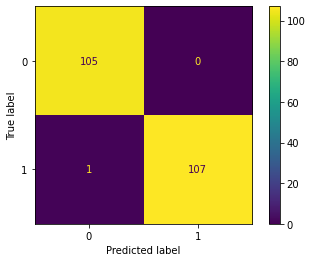

In [ ]:
cnf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat, display_labels=clf.classes_)
disp.plot()

### MLP

**NOTE**: We understand this model is not 100% correct and that because the last layer have to be with just 1 perceptron and sigmoidal activation. The reason of this implementation is the compatibility with the ART library.

In [ ]:
def to_one_hot(y, num_classes=None):
    if num_classes is None:
        num_classes = np.amax(y) + 1
    new_y = np.zeros((len(y), num_classes))
    for i, yi in enumerate(y):
        new_y[i][yi] = 1
    return new_y

def de_one_hot(y):
    new_y = np.argmax(y, axis=1)
    return new_y

In [ ]:
y_train = to_one_hot(y_train)
y_val = to_one_hot(y_val)
y_test = to_one_hot(y_test)


In [ ]:
# Create the model
model = Sequential()
model.add(Input(shape=(2048,)))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 1,221,698
Trainable params: 1,221,698
Non-trainable params: 0
_________________________________________________________________


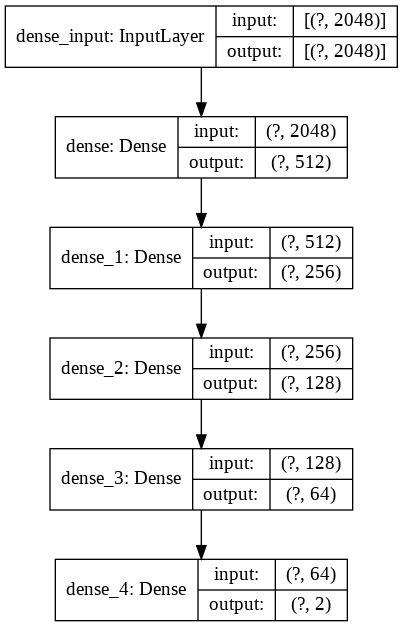

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [ 
             EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
             ModelCheckpoint(os.path.join('.', 'models', 'mlp_model.h5'), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
]

model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=Adam(lr=0.00001), metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=callbacks, verbose=1)

Train on 991 samples, validate on 212 samples
Epoch 1/100
991/991 [==============================] - 0s 341us/sample - loss: 0.5055 - accuracy: 0.9960 - val_loss: 0.5038 - val_accuracy: 1.0000
Epoch 2/100
991/991 [==============================] - 0s 171us/sample - loss: 0.5055 - accuracy: 0.9960 - val_loss: 0.5036 - val_accuracy: 1.0000
Epoch 3/100
991/991 [==============================] - 0s 167us/sample - loss: 0.5054 - accuracy: 0.9960 - val_loss: 0.5036 - val_accuracy: 1.0000
Epoch 4/100
991/991 [==============================] - 0s 442us/sample - loss: 0.5054 - accuracy: 0.9960 - val_loss: 0.5035 - val_accuracy: 1.0000
Epoch 5/100
991/991 [==============================] - 0s 161us/sample - loss: 0.5054 - accuracy: 0.9960 - val_loss: 0.5035 - val_accuracy: 1.0000
Epoch 6/100
991/991 [==============================] - 0s 184us/sample - loss: 0.5054 - accuracy: 0.9960 - val_loss: 0.5035 - val_accuracy: 1.0000
Epoch 7/100
991/991 [==============================] - 0s 100us/sample -

In [ ]:
# Load fitted model
model = tf.keras.models.load_model(os.path.join('.', 'models', 'mlp_model.h5'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# Test the model after training
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

213/213 [==============================] - 1s 4ms/sample - loss: 0.0708 - accuracy: 0.9906
Test results - Loss: 0.07077949640841394 - Accuracy: 0.9906103014945984%


In [ ]:
y_pred = de_one_hot(model.predict(X_test))

In [ ]:
y_test = de_one_hot(y_test)

In [ ]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.9907407407407407
Recall: 0.9907407407407407


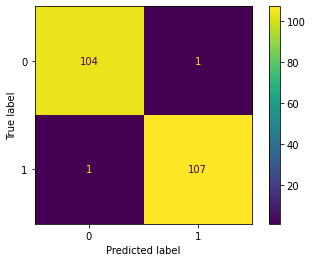

In [ ]:
cnf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat, display_labels=clf.classes_)
disp.plot()

## Attack 

### Load model and predispose the *attack*

We compose a net with the previous fitted model like in the following image:

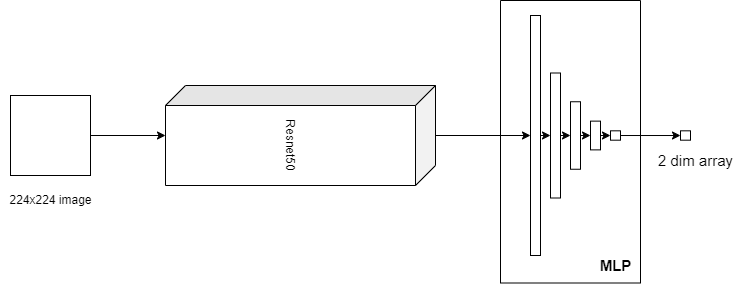

This is because we want to reconstruct adversarial images, not just embeddings.

For simplify the image recostruction we place the attack in the point signed with the arrow:
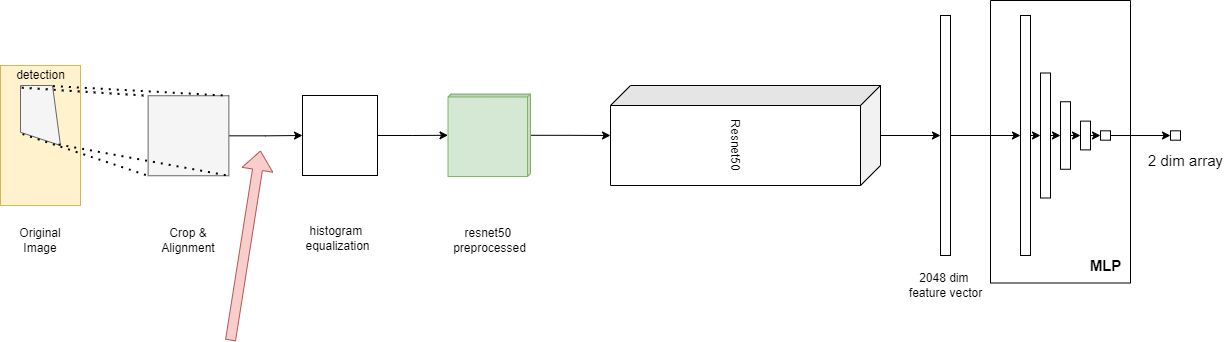

We can obviously recostruct the image with the inverse affine transormation, this is just for simplicity.

In [11]:
preprocesser = Preprocesser()

[INFO] loading face detector...
[INFO] loading face landmarks extractor...
[INFO] loading face aligner...
[INFO] Loading resnet50...
I Am  none
94699520/94694792 [==============================] - 6s 0us/step
[INFO] Preprocessor load.


In [12]:
model = tf.keras.models.load_model(os.path.join('.', 'models', 'mlp_model.h5'))

In [13]:
c_mlp = Sequential()
c_mlp.add(preprocesser._res50_model)
c_mlp.add(model)
# c_mlp.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=Adam(lr=0.00001), metrics=['accuracy'])
c_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 2048)              23561152  
_________________________________________________________________
sequential (Sequential)      (None, 2)                 1221698   
Total params: 24,782,850
Trainable params: 1,221,698
Non-trainable params: 23,561,152
_________________________________________________________________


In [14]:
classifier = KerasClassifier(c_mlp, clip_values=(0,255))

In [15]:
clf = pickle.load(open(os.path.join('.', 'models', 'svm_grid.model'), 'rb'))

### Load data

In [ ]:
df_test = pd.read_csv(os.path.join('.', 'data', 'df_test.csv'), index_col=None)

df_test_0 = df_test[df_test['id'] == 0]
df_test_1 = df_test[df_test['id'] == 1]

test_imgs_0 = [cv2.imread(df_test_0.iloc[i].file_path) for i in tqdm(range(len(df_test_0.index)), desc='Load test0')]
test_imgs_0 = [preprocesser.process(img, process_type='crop_align', embedd=False).astype('float64') for img in tqdm(test_imgs_0, desc='process test0')]
test_imgs_0 = np.array(test_imgs_0)

test_imgs_1 = [cv2.imread(df_test_1.iloc[i].file_path) for i in tqdm(range(len(df_test_1.index)), desc='Load test1')]
test_imgs_1 = [preprocesser.process(img, process_type='crop_align', embedd=False).astype('float64') for img in tqdm(test_imgs_1, desc='process test1')]
test_imgs_1 = np.array(test_imgs_1)

with open(os.path.join('.', 'data', 'test_imgs.pk'), 'wb') as f:
    pk.dump((test_imgs_0, test_imgs_1), f)

Load test0:   0%|          | 0/105 [00:00<?, ?it/s]

process test0:   0%|          | 0/105 [00:00<?, ?it/s]

Load test0:   0%|          | 0/108 [00:00<?, ?it/s]

process test0:   0%|          | 0/108 [00:00<?, ?it/s]

In [12]:
with open(os.path.join('.', 'data', 'test_imgs.pk'), 'rb') as f:
    test_imgs_0, test_imgs_1 = pk.load(f)

### FGSM

#### Single

perturbation: 9.89 - 3.88
true label: 0
mlp pred: 1
svm pred: 0
pred: 0


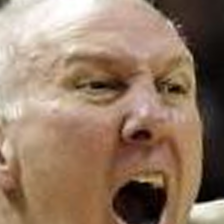

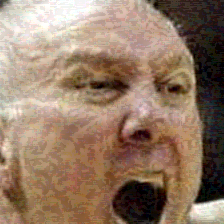

In [ ]:
EPSILON = 10
INDEX = 1
TRUE_LABEL = 0

img = test_imgs_0[INDEX]

attack = FastGradientMethod(estimator=classifier, eps=EPSILON, targeted=False)
image_adv = attack.generate(np.expand_dims(img, axis=0))

# Save perturbations
print('perturbation:', round(np.mean(np.abs((image_adv - img))),2), '-', f'{round(np.mean(np.abs((image_adv - img)))/255*100,2)}')

# Generate the embedding
embedding = preprocesser.process(image_adv[0].astype('uint8'), embedd=True, process_type='preprocess')

# Predict on the MLP (and SVM for trasfering)
print('true label:', TRUE_LABEL)
print('mlp pred:', np.argmax(model.predict(embedding)))
print('svm pred:', clf.predict(embedding)[0])

# Print the two images
print('pred:', np.argmax(classifier.predict(np.expand_dims(img, axis=0).astype('float64'))))
cv2_imshow(img)
cv2_imshow(image_adv[0])


#### Security Evaluation

##### Do not recognize

In [ ]:
EPSILONS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 35, 50, 100, 150, 200, 255]

In [ ]:
FILENAME = 'fgsm_1to0.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  fgsm_attack_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  fgsm_attack_1to0 = pd.DataFrame(columns=['epsilon', 'mean_perturbation', 'mlp_test_accuracy', 'svm_test_accuracy'])

y_test = np.array([1] * test_imgs_1.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
  # Generate the adversarial image
  attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=False)
  images_adv = attack.generate(test_imgs_1)

  # Save perturbations
  perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_1[i])) for i in range(len(images_adv))]

  # Generate the embeddings
  embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

  # Predict on the MLP (and SVM for trasfering)
  mlp_model_predictions_adv = [np.argmax(model.predict(embedding)) for embedding in tqdm(embeddings, desc='mlp predicting', leave=False)]
  svm_model_predictions_adv = [clf.predict(embedding) for embedding in tqdm(embeddings, desc='svm predicting', leave=False)]

  fgsm_attack_1to0 = fgsm_attack_1to0.append(dict(epsilon=epsilon,
                                                  mean_perturbation=statistics.mean(perturbations), 
                                                  mlp_test_accuracy=metrics.accuracy_score(y_test, mlp_model_predictions_adv),
                                                  svm_test_accuracy=metrics.accuracy_score(y_test, svm_model_predictions_adv)),
                                             ignore_index=True)

  fgsm_attack_1to0.to_csv(os.path.join('.', 'attack', FILENAME), index=False)


Text(0, 0.5, 'MLP Accuracy')

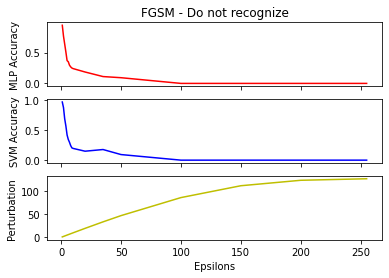

In [ ]:
FILENAME = 'fgsm_1to0.csv'

fgsm_attack_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

epsilon = fgsm_attack_1to0['epsilon'].tolist()
mean_perturbation = fgsm_attack_1to0['mean_perturbation'].tolist()
mlp_test_accuracy = fgsm_attack_1to0['mlp_test_accuracy'].tolist()
svm_test_accuracy = fgsm_attack_1to0['svm_test_accuracy'].tolist()

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].set_title("FGSM - Do not recognize")

ax[0].plot(epsilon, mlp_test_accuracy, 'r-')
ax[1].plot(epsilon, svm_test_accuracy, 'b-')
ax[2].plot(epsilon, mean_perturbation, 'y-')

ax[2].set_xlabel("Epsilons")
ax[2].set_ylabel("Perturbation")
ax[1].set_ylabel("SVM Accuracy")
ax[0].set_ylabel("MLP Accuracy")


##### Impersonate

In [ ]:
EPSILONS = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 255]

In [ ]:
FILENAME = 'fgsm_0to1.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  fgsm_attack_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  fgsm_attack_0to1 = pd.DataFrame(columns=['epsilon', 'mean_perturbation', 'mlp_test_accuracy', 'svm_test_accuracy'])

y_test = np.array([0] * test_imgs_0.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
  # Generate the adversarial image
  attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=False)
  images_adv = attack.generate(test_imgs_0)

  # Save perturbations
  perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_0[i])) for i in range(len(images_adv))]

  # Generate the embeddings
  embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

  # Predict on the MLP (and SVM for trasfering)
  mlp_model_predictions_adv = [np.argmax(model.predict(embedding)) for embedding in tqdm(embeddings, desc='mlp predicting', leave=False)]
  svm_model_predictions_adv = [clf.predict(embedding) for embedding in tqdm(embeddings, desc='svm predicting', leave=False)]

  fgsm_attack_0to1 = fgsm_attack_0to1.append(dict(epsilon=epsilon,
                                                  mean_perturbation=statistics.mean(perturbations), 
                                                  mlp_test_accuracy=metrics.accuracy_score(y_test, mlp_model_predictions_adv),
                                                  svm_test_accuracy=metrics.accuracy_score(y_test, svm_model_predictions_adv)),
                                             ignore_index=True)

  fgsm_attack_0to1.to_csv(os.path.join('.', 'attack', FILENAME), index=False)

Text(0, 0.5, 'MLP Accuracy')

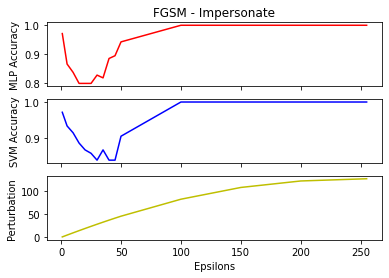

In [ ]:
FILENAME = 'fgsm_0to1.csv'

fgsm_attack_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

epsilon = fgsm_attack_0to1['epsilon'].tolist()
mean_perturbation = fgsm_attack_0to1['mean_perturbation'].tolist()
mlp_test_accuracy = fgsm_attack_0to1['mlp_test_accuracy'].tolist()
svm_test_accuracy = fgsm_attack_0to1['svm_test_accuracy'].tolist()

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].set_title("FGSM - Impersonate")

ax[0].plot(epsilon, mlp_test_accuracy, 'r-')
ax[1].plot(epsilon, svm_test_accuracy, 'b-')
ax[2].plot(epsilon, mean_perturbation, 'y-')

ax[2].set_xlabel("Epsilons")
ax[2].set_ylabel("Perturbation")
ax[1].set_ylabel("SVM Accuracy")
ax[0].set_ylabel("MLP Accuracy")


### BIM

#### Single

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/25 [00:00<?, ?it/s]

epsilon: 40 , max_iter: 25 

perturbation: 8.3 - 3.26%
true label: 0
mlp pred: 1
svm pred: 1

Original image


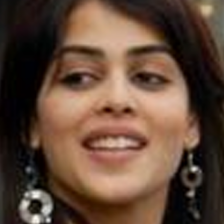

Adversarial image


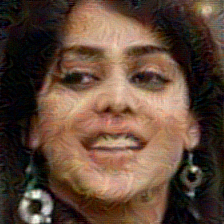

In [ ]:
EPSILON = 40
ITER = 25
EPSILON_STEP = EPSILON / ITER
INDEX = 9    # 18
TRUE_LABEL = 0

img = test_imgs_0[INDEX]

attack = BasicIterativeMethod(estimator=classifier, eps=EPSILON, eps_step=EPSILON_STEP, max_iter=ITER, targeted=False)
image_adv = attack.generate(np.expand_dims(img, axis=0))

print('epsilon:', EPSILON, ', max_iter:', ITER, '\n')

# Save perturbations
print('perturbation:', round(np.mean(np.abs((image_adv - img))), 2), '-', f'{round(np.mean(np.abs((image_adv - img)))/255*100, 2)}%')

# Generate the embedding
embedding = preprocesser.process(image_adv[0].astype('uint8'), embedd=True, process_type='preprocess')

# Predict on the MLP (and SVM for trasfering)
print('true label:', TRUE_LABEL)
print('mlp pred:', np.argmax(model.predict(embedding)))
print('svm pred:', clf.predict(embedding)[0])

print('\nOriginal image')
cv2_imshow(img)
print('Adversarial image')
cv2_imshow(image_adv[0])


#### Security Evaluation

##### Do not recognize

In [ ]:
EPSILONS = [1, 5, 10, 20, 40]  
ITERS = [10, 25, 50]

In [ ]:
FILENAME = 'bim_1to0.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  bim_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  bim_1to0 = pd.DataFrame(columns=['epsilon', 'epsilon_step', 'max_iter', 'mean_perturbation', 'mlp_test_accuracy', 'svm_test_accuracy'])

y_test = np.array([1] * test_imgs_1.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
  for max_iter in tqdm(ITERS, leave=False, desc='max iter'):
    epsilon_step = epsilon / max_iter

    # Generate the adversarial image
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False, verbose=False)
    images_adv = attack.generate(test_imgs_1)

    # Save perturbations
    perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_1[i])) for i in range(len(images_adv))]

    # Generate the embeddings
    embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

    # Predict on the MLP (and SVM for trasfering)
    mlp_model_predictions_adv = [np.argmax(model.predict(embedding)) for embedding in tqdm(embeddings, desc='mlp predicting', leave=False)]
    svm_model_predictions_adv = [clf.predict(embedding) for embedding in tqdm(embeddings, desc='svm predicting', leave=False)]

    bim_1to0 = bim_1to0.append(dict(epsilon=epsilon,
                                    epsilon_step=epsilon_step,
                                    max_iter=max_iter,
                                    mean_perturbation=statistics.mean(perturbations), 
                                    mlp_test_accuracy=metrics.accuracy_score(y_test, mlp_model_predictions_adv),
                                    svm_test_accuracy=metrics.accuracy_score(y_test, svm_model_predictions_adv)),
                              ignore_index=True)

    bim_1to0.to_csv(os.path.join('.', 'attack', FILENAME), index=False)


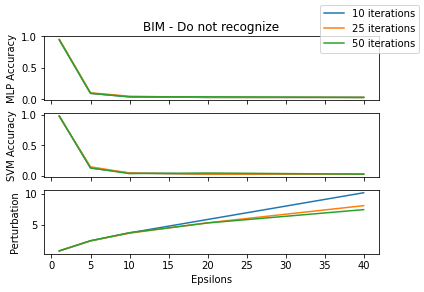

In [ ]:
FILENAME = 'bim_1to0.csv'

bim_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].set_title("BIM - Do not recognize")

for max_iter in ITERS:
  cut_bim_1to0 = bim_1to0[bim_1to0['max_iter'] == max_iter]

  epsilon = cut_bim_1to0['epsilon'].tolist()
  mean_perturbation = cut_bim_1to0['mean_perturbation'].tolist()
  mlp_test_accuracy = cut_bim_1to0['mlp_test_accuracy'].tolist()
  svm_test_accuracy = cut_bim_1to0['svm_test_accuracy'].tolist()

  ax[0].plot(epsilon, mlp_test_accuracy, label=f'{max_iter} iterations')
  ax[1].plot(epsilon, svm_test_accuracy)
  ax[2].plot(epsilon, mean_perturbation)

  ax[2].set_xlabel("Epsilons")
  ax[2].set_ylabel("Perturbation")
  ax[1].set_ylabel("SVM Accuracy")
  ax[0].set_ylabel("MLP Accuracy")

fig.legend()


##### Impersonate

In [ ]:
EPSILONS = [1, 5, 10, 20, 40]
ITERS = [10, 25, 50] 

In [ ]:
FILENAME = 'bim_0to1.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  bim_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  bim_0to1 = pd.DataFrame(columns=['epsilon', 'epsilon_step', 'max_iter', 'mean_perturbation', 'mlp_test_accuracy', 'svm_test_accuracy'])

y_test = np.array([0] * test_imgs_0.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
  for max_iter in tqdm(ITERS, leave=False, desc='max iter'):
    epsilon_step = epsilon / max_iter

    # Generate the adversarial image
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False, verbose=False)
    images_adv = attack.generate(test_imgs_0)

    # Save perturbations
    perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_0[i])) for i in range(len(images_adv))]

    # Generate the embeddings
    embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

    # Predict on the MLP (and SVM for trasfering)
    mlp_model_predictions_adv = [np.argmax(model.predict(embedding)) for embedding in tqdm(embeddings, desc='mlp predicting', leave=False)]
    svm_model_predictions_adv = [clf.predict(embedding) for embedding in tqdm(embeddings, desc='svm predicting', leave=False)]

    bim_0to1 = bim_0to1.append(dict(epsilon=epsilon,
                                    epsilon_step=epsilon_step,
                                    max_iter=max_iter,
                                    mean_perturbation=statistics.mean(perturbations), 
                                    mlp_test_accuracy=metrics.accuracy_score(y_test, mlp_model_predictions_adv),
                                    svm_test_accuracy=metrics.accuracy_score(y_test, svm_model_predictions_adv)),
                               ignore_index=True)

    bim_0to1.to_csv(os.path.join('.', 'attack', FILENAME), index=False)
  

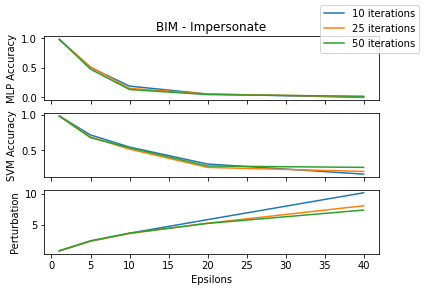

In [ ]:
FILENAME = 'bim_0to1.csv'

bim_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].set_title("BIM - Impersonate")

for max_iter in ITERS:
  cut_bim_0to1 = bim_0to1[bim_0to1['max_iter'] == max_iter]

  epsilon = cut_bim_0to1['epsilon'].tolist()
  mean_perturbation = cut_bim_0to1['mean_perturbation'].tolist()
  mlp_test_accuracy = cut_bim_0to1['mlp_test_accuracy'].tolist()
  svm_test_accuracy = cut_bim_0to1['svm_test_accuracy'].tolist()

  ax[0].plot(epsilon, mlp_test_accuracy, label=f'{max_iter} iterations')
  ax[1].plot(epsilon, svm_test_accuracy)
  ax[2].plot(epsilon, mean_perturbation)

  ax[2].set_xlabel("Epsilons")
  ax[2].set_ylabel("Perturbation")
  ax[1].set_ylabel("SVM Accuracy")
  ax[0].set_ylabel("MLP Accuracy")

fig.legend()


### PGD

#### Single

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

perturbation: 5.69 - 2.23%
true label: 0
mlp pred: 1
svm pred: 0

Original image


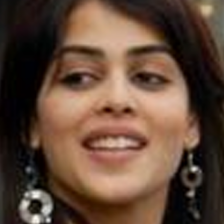

Adversarial image


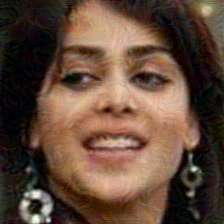

In [ ]:
EPSILON = 20
ITER = 10
EPSILON_STEP = EPSILON / ITER
INDEX = 9
TRUE_LABEL = 0

img = test_imgs_0[INDEX]

attack = ProjectedGradientDescent(estimator=classifier, eps=EPSILON, eps_step=EPSILON_STEP, max_iter=ITER, targeted=False)
image_adv = attack.generate(np.expand_dims(img, axis=0))

# Save perturbations
print('perturbation:', round(np.mean(np.abs((image_adv - img))), 2), '-', f'{round(np.mean(np.abs((image_adv - img)))/255*100, 2)}%')

# Generate the embedding
embedding = preprocesser.process(image_adv[0].astype('uint8'), embedd=True, process_type='preprocess')

# Predict on the MLP (and SVM for trasfering)
print('true label:', TRUE_LABEL)
print('mlp pred:', np.argmax(model.predict(embedding)))
print('svm pred:', clf.predict(embedding)[0])

print('\nOriginal image')
cv2_imshow(img)
print('Adversarial image')
cv2_imshow(image_adv[0])


#### Security Evaluation

##### Do not recognize

In [16]:
EPSILONS = [1, 5, 10, 20, 40] 
ITERS = [10, 25, 50]

In [ ]:
FILENAME = 'pgd_1to0.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  pgd_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  pgd_1to0 = pd.DataFrame(columns=['epsilon', 'epsilon_step', 'max_iter', 'mean_perturbation', 'mlp_test_accuracy', 'svm_test_accuracy'])

y_test = np.array([1] * test_imgs_1.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
  for max_iter in tqdm(ITERS, leave=False, desc='max iter'):
    epsilon_step = epsilon / max_iter

    # Generate the adversarial image
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False, verbose=False)
    images_adv = attack.generate(test_imgs_1)

    # Save perturbations
    perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_1[i])) for i in range(len(images_adv))]

    # Generate the embeddings
    embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

    # Predict on the MLP (and SVM for trasfering)
    mlp_model_predictions_adv = [np.argmax(model.predict(embedding)) for embedding in tqdm(embeddings, desc='mlp predicting', leave=False)]
    svm_model_predictions_adv = [clf.predict(embedding) for embedding in tqdm(embeddings, desc='svm predicting', leave=False)]

    pgd_1to0 = pgd_1to0.append(dict(epsilon=epsilon,
                                    epsilon_step=epsilon_step,
                                    max_iter=max_iter,
                                    mean_perturbation=statistics.mean(perturbations), 
                                    mlp_test_accuracy=metrics.accuracy_score(y_test, mlp_model_predictions_adv),
                                    svm_test_accuracy=metrics.accuracy_score(y_test, svm_model_predictions_adv)),
                              ignore_index=True)

    pgd_1to0.to_csv(os.path.join('.', 'attack', FILENAME), index=False)


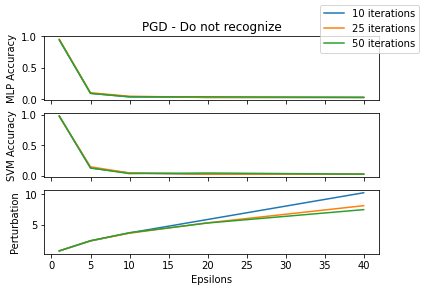

In [17]:
FILENAME = 'pgd_1to0.csv'

pgd_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].set_title("PGD - Do not recognize")

for max_iter in ITERS:
  cut_pgd_1to0 = pgd_1to0[pgd_1to0['max_iter'] == max_iter]

  epsilon = cut_pgd_1to0['epsilon'].tolist()
  mean_perturbation = cut_pgd_1to0['mean_perturbation'].tolist()
  mlp_test_accuracy = cut_pgd_1to0['mlp_test_accuracy'].tolist()
  svm_test_accuracy = cut_pgd_1to0['svm_test_accuracy'].tolist()

  ax[0].plot(epsilon, mlp_test_accuracy, label=f'{max_iter} iterations')
  ax[1].plot(epsilon, svm_test_accuracy)
  ax[2].plot(epsilon, mean_perturbation)

  ax[2].set_xlabel("Epsilons")
  ax[2].set_ylabel("Perturbation")
  ax[1].set_ylabel("SVM Accuracy")
  ax[0].set_ylabel("MLP Accuracy")

fig.legend()


##### Impersonate

In [18]:
EPSILONS = [1, 5, 10, 20, 40]
ITERS = [10, 25, 50]

In [ ]:
FILENAME = 'pgd_0to1_1.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  pgd_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  pgd_0to1 = pd.DataFrame(columns=['epsilon', 'epsilon_step', 'max_iter', 'mean_perturbation', 'mlp_test_accuracy', 'svm_test_accuracy'])

y_test = np.array([0] * test_imgs_0.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
  for max_iter in tqdm(ITERS, leave=False, desc='max iter'):
    epsilon_step = epsilon / max_iter

    # Generate the adversarial image
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False, verbose=False)
    images_adv = attack.generate(test_imgs_0)

    # Save perturbations
    perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_0[i])) for i in range(len(images_adv))]

    # Generate the embeddings
    embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

    # Predict on the MLP (and SVM for trasfering)
    mlp_model_predictions_adv = [np.argmax(model.predict(embedding)) for embedding in tqdm(embeddings, desc='mlp predicting', leave=False)]
    svm_model_predictions_adv = [clf.predict(embedding) for embedding in tqdm(embeddings, desc='svm predicting', leave=False)]

    pgd_0to1 = pgd_0to1.append(dict(epsilon=epsilon,
                                    epsilon_step=epsilon_step,
                                    max_iter=max_iter,
                                    mean_perturbation=statistics.mean(perturbations), 
                                    mlp_test_accuracy=metrics.accuracy_score(y_test, mlp_model_predictions_adv),
                                    svm_test_accuracy=metrics.accuracy_score(y_test, svm_model_predictions_adv)),
                              ignore_index=True)

    pgd_0to1.to_csv(os.path.join('.', 'attack', FILENAME), index=False)


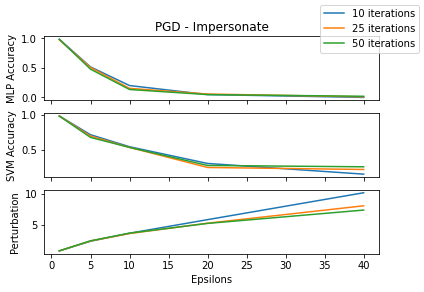

In [19]:
FILENAME = 'pgd_0to1.csv'

pgd_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

fig, ax = plt.subplots(3, 1, sharex=True)
ax[0].set_title("PGD - Impersonate")

for max_iter in ITERS:
  cut_pgd_0to1 = pgd_0to1[pgd_0to1['max_iter'] == max_iter]

  epsilon = cut_pgd_0to1['epsilon'].tolist()
  mean_perturbation = cut_pgd_0to1['mean_perturbation'].tolist()
  mlp_test_accuracy = cut_pgd_0to1['mlp_test_accuracy'].tolist()
  svm_test_accuracy = cut_pgd_0to1['svm_test_accuracy'].tolist()

  ax[0].plot(epsilon, mlp_test_accuracy, label=f'{max_iter} iterations')
  ax[1].plot(epsilon, svm_test_accuracy)
  ax[2].plot(epsilon, mean_perturbation)

  ax[2].set_xlabel("Epsilons")
  ax[2].set_ylabel("Perturbation")
  ax[1].set_ylabel("SVM Accuracy")
  ax[0].set_ylabel("MLP Accuracy")

fig.legend()


### DeepFool
(Does not Work)

In [ ]:
from art.attacks.evasion import DeepFool


#### Single

In [ ]:
EPSILON = 1e-20
ITER = 100

df_test_cut = df_test[df_test['id'] == 1]

imgs = [cv2.imread(df_test_cut.iloc[i].file_path) for i in range(5)]
imgs = [preprocesser.process(img, process_type='crop_align', embedd=False).astype('float64') for img in imgs]
imgs = np.array(imgs)

attack = DeepFool(classifier=classifier, epsilon=EPSILON, max_iter=ITER, nb_grads=15)
    
#img = cv2.imread(df_test_cut.iloc[INDEX].file_path)
#img = preprocesser.process(img, process_type='crop_align', embedd=False).astype('float64')
imagse_adv = attack.generate(imgs)


DeepFool:   0%|          | 0/5 [00:00<?, ?it/s]

perturbation: 0.006313188676561248
true label: 1
mlp pred: 1
svm pred: 1


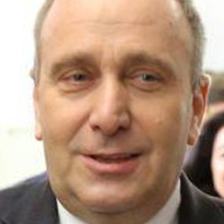

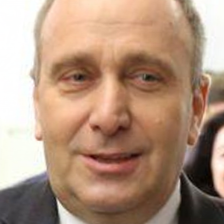





perturbation: 53.86828487444647
true label: 1
mlp pred: 0
svm pred: 0


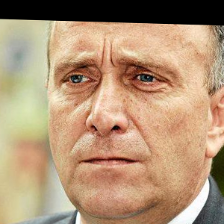

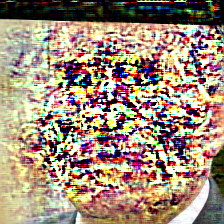





perturbation: 0.004952209365715162
true label: 1
mlp pred: 1
svm pred: 1


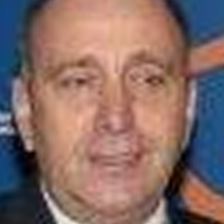

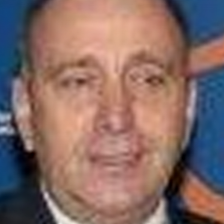





perturbation: 68.60519182526362
true label: 1
mlp pred: 0
svm pred: 0


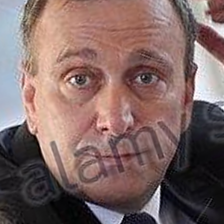

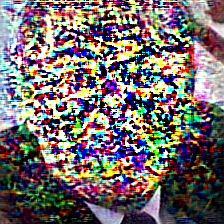





perturbation: 1.0006439741399455
true label: 1
mlp pred: 0
svm pred: 0


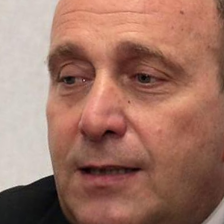

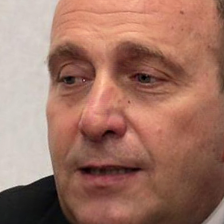

In [ ]:
#INDEX = 5

for INDEX in range(5):
    image_adv = imagse_adv[INDEX]
    img = imgs[INDEX]

    # Save perturbations
    print('perturbation:', np.mean(np.abs((image_adv - img))))

    # Generate the embedding
    embedding = preprocesser.process(image_adv.astype('uint8'), embedd=True, process_type='preprocess')

    # Predict on the MLP (and SVM for trasfering)
    print('true label:', df_test_cut.iloc[INDEX].id)
    print('mlp pred:', np.argmax(model.predict(embedding)))
    print('svm pred:', clf.predict(embedding)[0])

    # Print the two images
    cv2_imshow(img)
    cv2_imshow(image_adv)

    print('\n\n\n')

### CarliniL2
(Does not Work)

In [ ]:
from art.attacks.evasion import CarliniL2Method


#### Single

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

perturbation: 0.0
true label: 1
mlp pred: 1
svm pred: 1


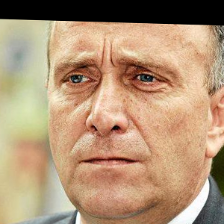

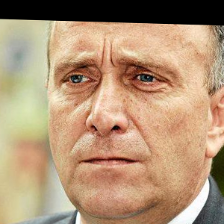

In [ ]:
cw_params = {'binary_search_steps': 20, 
             'abort_early' : False, 
             'max_iterations': 250, 
             'learning_rate': 0.9,
             'initial_const': 100,
             'confidence': 70, 
             'clip_min': -1.0, 
             'clip_max': 1.0 
            }

INDEX = 1

df_test_cut = df_test[df_test['id'] == 1]

attack = CarliniL2Method(classifier=classifier)
img = cv2.imread(df_test_cut.iloc[INDEX].file_path)
img = preprocesser.process(img, process_type='crop_align', embedd=False).astype('float64')
image_adv = attack.generate(np.expand_dims(img, axis=0), **cw_params)

# Save perturbations
print('perturbation:', np.mean(np.abs((image_adv - img))))

# Generate the embedding
embedding = preprocesser.process(image_adv[0].astype('uint8'), embedd=True, process_type='preprocess')

# Predict on the MLP (and SVM for trasfering)
print('true label:', df_test_cut.iloc[INDEX].id)
print('mlp pred:', np.argmax(model.predict(embedding)))
print('svm pred:', clf.predict(embedding)[0])

cv2_imshow(img)
cv2_imshow(image_adv[0])

### Extra photo


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

epsilon: 5 , max_iter: 50 

perturbation: 2.42 - 0.95%
true label: 0
mlp pred: 1
svm pred: 1

Original image


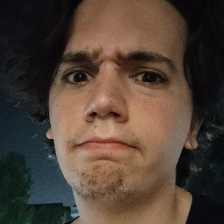

Adversarial image


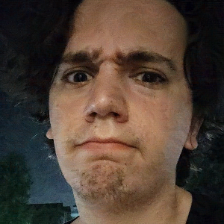

In [ ]:
EPSILON = 5
ITER = 50
EPSILON_STEP = EPSILON / ITER
INDEX = 0    # 18
TRUE_LABEL = 0

i = cv2.imread(os.path.join('.', 'our_photos', 'photo_alessio.jpeg'))
i = preprocesser.process(i, process_type='crop_align', embedd=False).astype('float64')
img = i
img = np.array(img)

attack = ProjectedGradientDescent(estimator=classifier, eps=EPSILON, eps_step=EPSILON_STEP, max_iter=ITER, targeted=False)
image_adv = attack.generate(np.expand_dims(img, axis=0))

print('epsilon:', EPSILON, ', max_iter:', ITER, '\n')

# Save perturbations
print('perturbation:', round(np.mean(np.abs((image_adv - img))), 2), '-', f'{round(np.mean(np.abs((image_adv - img)))/255*100, 2)}%')

# Generate the embedding
embedding = preprocesser.process(image_adv[0].astype('uint8'), embedd=True, process_type='preprocess')

# Predict on the MLP (and SVM for trasfering)
print('true label:', TRUE_LABEL)
print('mlp pred:', np.argmax(model.predict(embedding)))
print('svm pred:', clf.predict(embedding)[0])

print('\nOriginal image')
cv2_imshow(img)
print('Adversarial image')
cv2_imshow(image_adv[0])


## Defence

### Generate adversarial samples

First of all, we load and align the training set.

In [ ]:
df_train = pd.read_csv(os.path.join('.', 'data', 'df_train.csv'), index_col=None)

imgs = [cv2.imread(df_train.iloc[i].file_path) for i in tqdm(range(len(df_train.index)), desc='Load data', leave=False)]
imgs = [preprocesser.process(img, process_type='crop_align', embedd=False).astype('float64') for img in tqdm(imgs, desc='process data', leave=False)]
imgs = np.array(imgs)
ids = np.array(df_train['id'].tolist())

with open(os.path.join('.', 'data', 'train_imgs.pk'), 'wb') as f:
  pk.dump((imgs, ids), f)

Load data:   0%|          | 0/991 [00:00<?, ?it/s]

process data:   0%|          | 0/991 [00:00<?, ?it/s]

In [ ]:
with open(os.path.join('.', 'data', 'train_imgs.pk'), 'rb') as f:
  tr_imgs, tr_ids = pk.load(f)

or validation set

In [ ]:
df_train = pd.read_csv(os.path.join('.', 'data', 'df_val.csv'), index_col=None)

imgs = [cv2.imread(df_train.iloc[i].file_path) for i in tqdm(range(len(df_train.index)), desc='Load data', leave=False)]
imgs = [preprocesser.process(img, process_type='crop_align', embedd=False).astype('float64') for img in tqdm(imgs, desc='process data', leave=False)]
imgs = np.array(imgs)
ids = np.array(df_train['id'].tolist())

with open(os.path.join('.', 'data', 'train_imgs.pk'), 'wb') as f:
  pk.dump((imgs, ids), f)

Load data:   0%|          | 0/212 [00:00<?, ?it/s]

process data:   0%|          | 0/212 [00:00<?, ?it/s]

In [ ]:
with open(os.path.join('.', 'data', 'train_imgs.pk'), 'rb') as f:
  val_imgs, val_ids = pk.load(f)

After, we define some attacks and use all of that to generate adversarial sample on the dataset, to have the same number of samples.

**NOTE**: This is our parameters for BIM. You can find the other attack in the report.

In [ ]:
attacks = [
           BasicIterativeMethod(estimator=classifier, eps=1, eps_step=0.1, max_iter=10, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=1, eps_step=0.06666666666666667, max_iter=15, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=1, eps_step=0.05, max_iter=20, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=1, eps_step=0.04, max_iter=25, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=4, eps_step=0.4, max_iter=10, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=4, eps_step=0.26666666666666666, max_iter=15, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=4, eps_step=0.2, max_iter=20, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=4, eps_step=0.16, max_iter=25, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=7, eps_step=0.7, max_iter=10, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=7, eps_step=0.4666666666666667, max_iter=15, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=7, eps_step=0.35, max_iter=20, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=7, eps_step=0.28, max_iter=25, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=10, eps_step=1.0, max_iter=10, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=10, eps_step=0.6666666666666666, max_iter=15, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=10, eps_step=0.5, max_iter=20, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=10, eps_step=0.4, max_iter=25, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=13, eps_step=1.3, max_iter=10, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=13, eps_step=0.8666666666666667, max_iter=15, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=13, eps_step=0.65, max_iter=20, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=13, eps_step=0.52, max_iter=25, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=16, eps_step=1.6, max_iter=10, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=16, eps_step=1.0666666666666667, max_iter=15, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=16, eps_step=0.8, max_iter=20, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=16, eps_step=0.64, max_iter=25, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=19, eps_step=1.9, max_iter=10, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=19, eps_step=1.2666666666666666, max_iter=15, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=19, eps_step=0.95, max_iter=20, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=19, eps_step=0.76, max_iter=25, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=22, eps_step=2.2, max_iter=10, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=22, eps_step=1.4666666666666666, max_iter=15, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=22, eps_step=1.1, max_iter=20, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=22, eps_step=0.88, max_iter=25, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=25, eps_step=2.5, max_iter=10, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=25, eps_step=1.6666666666666667, max_iter=15, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=25, eps_step=1.25, max_iter=20, targeted=False, verbose=False),
           BasicIterativeMethod(estimator=classifier, eps=25, eps_step=1.0, max_iter=25, targeted=False, verbose=False),
]

adversarial_imgs = []
for i in tqdm(range(len(imgs))):
  adversarial_imgs.append(attacks[i % len(attacks)].generate(np.expand_dims(tr_imgs[i], axis=0))[0])
adversarial_imgs = np.array(adversarial_imgs)

with open(os.path.join('.', 'data', 'adv_train_imgs_b_ranged_ext.pk'), 'wb') as f:
  pk.dump((adversarial_imgs, tr_ids), f)

adversarial_imgs = []
for i in tqdm(range(len(imgs))):
  adversarial_imgs.append(attacks[i % len(attacks)].generate(np.expand_dims(val_imgs[i], axis=0))[0])
adversarial_imgs = np.array(adversarial_imgs)

with open(os.path.join('.', 'data', 'adv_val_imgs_b_ranged_ext.pk'), 'wb') as f:
  pk.dump((adversarial_imgs, val_ids), f)


  0%|          | 0/991 [00:00<?, ?it/s]

In [ ]:
with open(os.path.join('.', 'data', 'adv_train_imgs_b_ranged_ext.pk'), 'rb') as f:
  tr_adversarial_imgs, tr_ids = pk.load(f)

with open(os.path.join('.', 'data', 'adv_val_imgs_b_ranged_ext.pk'), 'rb') as f:
  val_adversarial_imgs, val_ids = pk.load(f)

Embedd images 

In [ ]:
adversarial_embeddings = [preprocesser.process(tr_adversarial_imgs[i].astype('uint8'), embedd=True, process_type='preprocess').tolist()[0] for i in tqdm(range(tr_adversarial_imgs.shape[0]))]
df_adv_emb = pd.DataFrame(data=dict(X=adversarial_embeddings, y=tr_ids.tolist()))
df_adv_emb.to_csv(os.path.join('.', 'data', f'adv_train_emb_b_ranged_ext.csv'), index=False)

adversarial_embeddings = [preprocesser.process(val_adversarial_imgs[i].astype('uint8'), embedd=True, process_type='preprocess').tolist()[0] for i in tqdm(range(val_adversarial_imgs.shape[0]))]
df_adv_emb = pd.DataFrame(data=dict(X=adversarial_embeddings, y=val_ids.tolist()))
df_adv_emb.to_csv(os.path.join('.', 'data', f'adv_val_emb_b_ranged_ext.csv'), index=False)


  0%|          | 0/991 [00:00<?, ?it/s]

### Detector

In [ ]:
df = pd.read_csv(os.path.join('.', 'data', 'embedded_train.csv'))
X_train = [ast.literal_eval(x) for x in df['X'].tolist()]
y_train = [0] * len(X_train)

df = pd.read_csv(os.path.join('.', 'data', 'embedded_val.csv'))
X_val = [ast.literal_eval(x) for x in df['X'].tolist()]
y_val = [0] * len(X_val)

df = pd.read_csv(os.path.join('.', 'data', 'embedded_test.csv'))
X_test = [ast.literal_eval(x) for x in df['X'].tolist()]
y_test = [0] * len(X_test)

df = pd.read_csv(os.path.join('.', 'data', 'adv_train_emb_b_ranged_ext.csv'))
X_train_adv = [ast.literal_eval(x) for x in df['X'].tolist()]
y_train_adv = [1] * len(X_train_adv)

df = pd.read_csv(os.path.join('.', 'data', 'adv_val_emb_b_ranged_ext.csv'))
X_val_adv = [ast.literal_eval(x) for x in df['X'].tolist()]
y_val_adv = [1] * len(X_val_adv)

In [ ]:
X_train = np.array(X_train + X_train_adv)
y_train = np.array(y_train + y_train_adv)

X_val = np.array(X_val + X_val_adv)
y_val = np.array(y_val + y_val_adv)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
X_train, y_train = shuffle(np.array(X_train), np.array(y_train), random_state=45)
X_val, y_val = shuffle(np.array(X_val), np.array(y_val), random_state=45)
X_test, y_test = shuffle(np.array(X_test), np.array(y_test), random_state=45)

In [ ]:
# Create the model
dmodel = Sequential()
dmodel.add(Input(shape=(2048,)))
dmodel.add(Dense(1024, activation='relu'))
dmodel.add(Dense(256, activation='relu'))
dmodel.add(Dense(64, activation='relu'))
dmodel.add(Dense(1, activation='sigmoid'))

dmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 2,377,089
Trainable params: 2,377,089
Non-trainable params: 0
_________________________________________________________________


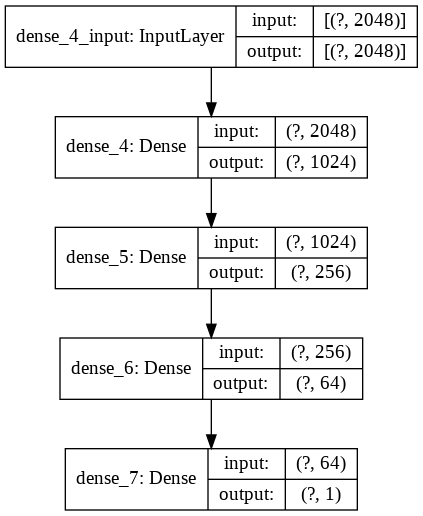

In [ ]:
tf.keras.utils.plot_model(dmodel, show_shapes=True)

In [ ]:
callbacks = [ 
             EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
             ModelCheckpoint(os.path.join('.', 'models', 'detector_b_ranged_ext.h5'), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
]

dmodel.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=Adam(lr=0.001), metrics=['accuracy'])
dmodel.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=callbacks, verbose=1)

Train on 1982 samples, validate on 424 samples
Epoch 1/100
1982/1982 [==============================] - 11s 6ms/sample - loss: 0.5864 - accuracy: 0.8042 - val_loss: 0.3825 - val_accuracy: 0.8561
Epoch 2/100
1982/1982 [==============================] - 1s 600us/sample - loss: 0.2666 - accuracy: 0.9016 - val_loss: 0.2844 - val_accuracy: 0.8915
Epoch 3/100
1982/1982 [==============================] - 1s 529us/sample - loss: 0.2119 - accuracy: 0.9193 - val_loss: 0.2867 - val_accuracy: 0.8821
Epoch 4/100
1982/1982 [==============================] - 1s 524us/sample - loss: 0.2095 - accuracy: 0.9188 - val_loss: 0.3336 - val_accuracy: 0.8514
Epoch 5/100
1982/1982 [==============================] - 1s 534us/sample - loss: 0.2024 - accuracy: 0.9183 - val_loss: 0.3061 - val_accuracy: 0.8986
Epoch 6/100
1982/1982 [==============================] - 1s 527us/sample - loss: 0.1361 - accuracy: 0.9420 - val_loss: 0.3208 - val_accuracy: 0.8844
Epoch 7/100
1982/1982 [==============================] - 1s 

In [16]:
dmodel = tf.keras.models.load_model(os.path.join('.', 'models', 'detector_b_ranged_ext.h5'))

In [ ]:
# Test the model after training
test_results = dmodel.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

213/213 [==============================] - 1s 6ms/sample - loss: 0.1455 - accuracy: 0.9671
Test results - Loss: 0.14553383846238185 - Accuracy: 0.9671361446380615%


In [ ]:
y_pred = np.rint(dmodel.predict(X_test))

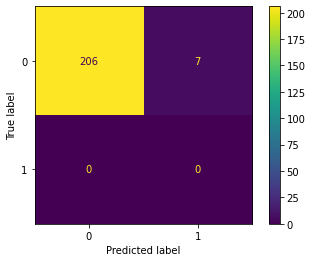

In [ ]:
cnf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mat, display_labels=clf.classes_)
disp.plot()

In [ ]:
df_test = pd.read_csv(os.path.join('.', 'data', 'df_test.csv'), index_col=None)

df_test_0 = df_test[df_test['id'] == 0]
df_test_1 = df_test[df_test['id'] == 1]

test_imgs_0 = [cv2.imread(df_test_0.iloc[i].file_path) for i in tqdm(range(len(df_test_0.index)), desc='Load test0')]
test_imgs_0 = [preprocesser.process(img, process_type='crop_align', embedd=False).astype('float64') for img in tqdm(test_imgs_0, desc='process test0')]
test_imgs_0 = np.array(test_imgs_0)

test_imgs_1 = [cv2.imread(df_test_1.iloc[i].file_path) for i in tqdm(range(len(df_test_1.index)), desc='Load test0')]
test_imgs_1 = [preprocesser.process(img, process_type='crop_align', embedd=False).astype('float64') for img in tqdm(test_imgs_1, desc='process test0')]
test_imgs_1 = np.array(test_imgs_1)

Load test0:   0%|          | 0/105 [00:00<?, ?it/s]

process test0:   0%|          | 0/105 [00:00<?, ?it/s]

Load test0:   0%|          | 0/108 [00:00<?, ?it/s]

process test0:   0%|          | 0/108 [00:00<?, ?it/s]

In [ ]:
with open(os.path.join('.', 'data', 'test_imgs.pk'), 'rb') as f:
  test_imgs_0, test_imgs_1 = pk.load(f)

### FGSM

#### Do not recognize

In [ ]:
EPSILONS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 35, 50, 100, 150, 200, 255]

In [ ]:
FILENAME = 'fgsm_1to0_det_ext.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  fgsm_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  fgsm_1to0 = pd.DataFrame(columns=['epsilon', 'mean_perturbation', 'detection_accuracy'])

y_test = np.array([1] * test_imgs_1.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
    # Generate the adversarial image
    attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=False)
    images_adv = attack.generate(test_imgs_1)

    # Save perturbations
    perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_1[i])) for i in range(len(images_adv))]

    # Generate the embeddings
    embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

    # Predict on the MLP (and SVM for trasfering)
    y_pred = np.rint(dmodel.predict(embeddings))
    y_test = np.array([1] * len(y_pred))

    fgsm_1to0 = fgsm_1to0.append(dict(epsilon=epsilon,
                                      mean_perturbation=statistics.mean(perturbations), 
                                      detection_accuracy=metrics.accuracy_score(y_test, y_pred)),
                                 ignore_index=True)

    fgsm_1to0.to_csv(os.path.join('.', 'attack', FILENAME), index=False)


In [ ]:
FILENAME = 'fgsm_1to0_det_ext.csv'

fgsm_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_title("FGSM - Detector accuracy - Do not Recognize")

epsilon = cut_fgsm_1to0['epsilon'].tolist()
mean_perturbation = cut_fgsm_1to0['mean_perturbation'].tolist()
detection_accuracy = cut_fgsm_1to0['detection_accuracy'].tolist()

ax[0].plot(epsilon, detection_accuracy, label=f'{max_iter} iterations')
ax[1].plot(epsilon, mean_perturbation)

ax[1].set_xlabel("Epsilons")
ax[1].set_ylabel("Perturbation")
ax[0].set_ylabel("Detector Accuracy")

fig.legend()


#### Impersonate

In [ ]:
EPSILONS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 35, 50, 100, 150, 200, 255]

In [ ]:
FILENAME = 'fgsm_0to1_det_ext.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  fgsm_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  fgsm_0to1 = pd.DataFrame(columns=['epsilon', 'mean_perturbation', 'detection_accuracy'])

y_test = np.array([0] * test_imgs_0.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
    # Generate the adversarial image
    attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=False)
    images_adv = attack.generate(test_imgs_0)

    # Save perturbations
    perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_0[i])) for i in range(len(images_adv))]

    # Generate the embeddings
    embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

    # Predict on the MLP (and SVM for trasfering)
    y_pred = np.rint(dmodel.predict(embeddings))
    y_test = np.array([1] * len(y_pred))

    fgsm_0to1 = fgsm_0to1.append(dict(epsilon=epsilon,
                                    mean_perturbation=statistics.mean(perturbations), 
                                    detection_accuracy=metrics.accuracy_score(y_test, y_pred)),
                                ignore_index=True)

    fgsm_0to1.to_csv(os.path.join('.', 'attack', FILENAME), index=False)


In [ ]:
FILENAME = 'fgsm_0to1_det_ext.csv'

fgsm_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_title("FGSM - Detector Accuracy - Impersonate              ")

for max_iter in ITERS:
  cut_fgsm_0to1 = fgsm_0to1[fgsm_0to1['max_iter'] == max_iter]

  epsilon = cut_fgsm_0to1['epsilon'].tolist()
  mean_perturbation = cut_fgsm_0to1['mean_perturbation'].tolist()
  detection_accuracy = cut_fgsm_0to1['detection_accuracy'].tolist()

  ax[0].plot(epsilon, detection_accuracy, label=f'{max_iter} iterations')
  ax[1].plot(epsilon, mean_perturbation)

  ax[1].set_xlabel("Epsilons")
  ax[1].set_ylabel("Perturbation")
  ax[0].set_ylabel("Detector Accuracy")

fig.legend()


### BIM

#### Do not recognize

In [ ]:
EPSILONS = [1, 3, 5, 7, 10, 20, 40] 
ITERS = [10, 25, 50]

In [ ]:
FILENAME = 'bim_1to0_det_ext.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  bim_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  bim_1to0 = pd.DataFrame(columns=['epsilon', 'epsilon_step', 'max_iter', 'mean_perturbation', 'detection_accuracy'])

y_test = np.array([1] * test_imgs_1.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
  for max_iter in tqdm(ITERS, leave=False, desc='max iter'):
    epsilon_step = epsilon / max_iter

    # Generate the adversarial image
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False, verbose=False)
    images_adv = attack.generate(test_imgs_1)

    # Save perturbations
    perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_1[i])) for i in range(len(images_adv))]

    # Generate the embeddings
    embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

    # Predict on the MLP (and SVM for trasfering)
    y_pred = np.rint(dmodel.predict(embeddings))
    y_test = np.array([1] * len(y_pred))

    bim_1to0 = bim_1to0.append(dict(epsilon=epsilon,
                                    epsilon_step=epsilon_step,
                                    max_iter=max_iter,
                                    mean_perturbation=statistics.mean(perturbations), 
                                    detection_accuracy=metrics.accuracy_score(y_test, y_pred)),
                              ignore_index=True)

    bim_1to0.to_csv(os.path.join('.', 'attack', FILENAME), index=False)


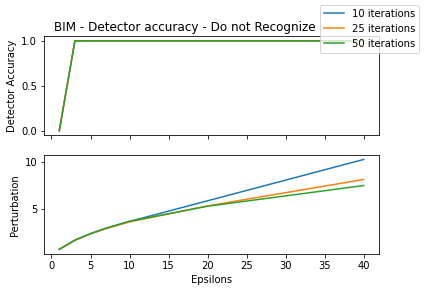

In [ ]:
FILENAME = 'bim_1to0_det_ext.csv'

bim_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_title("BIM - Detector accuracy - Do not Recognize              ")

for max_iter in ITERS:
  cut_bim_1to0 = bim_1to0[bim_1to0['max_iter'] == max_iter]

  epsilon = cut_bim_1to0['epsilon'].tolist()
  mean_perturbation = cut_bim_1to0['mean_perturbation'].tolist()
  detection_accuracy = cut_bim_1to0['detection_accuracy'].tolist()

  ax[0].plot(epsilon, detection_accuracy, label=f'{max_iter} iterations')
  ax[1].plot(epsilon, mean_perturbation)

  ax[1].set_xlabel("Epsilons")
  ax[1].set_ylabel("Perturbation")
  ax[0].set_ylabel("Detector Accuracy")

fig.legend()


#### Impersonate

In [13]:
EPSILONS = [1, 3, 5, 10, 20, 40] 
ITERS = [10, 25, 50]


In [ ]:
FILENAME = 'bim_0to1_det_ext.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  bim_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  bim_0to1 = pd.DataFrame(columns=['epsilon', 'epsilon_step', 'max_iter', 'mean_perturbation', 'detection_accuracy'])

y_test = np.array([0] * test_imgs_0.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
  for max_iter in tqdm(ITERS, leave=False, desc='max iter'):
    epsilon_step = epsilon / max_iter

    # Generate the adversarial image
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False, verbose=False)
    images_adv = attack.generate(test_imgs_0)

    # Save perturbations
    perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_0[i])) for i in range(len(images_adv))]

    # Generate the embeddings
    embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

    # Predict on the MLP (and SVM for trasfering)
    y_pred = np.rint(dmodel.predict(embeddings))
    y_test = np.array([1] * len(y_pred))

    bim_0to1 = bim_0to1.append(dict(epsilon=epsilon,
                                    epsilon_step=epsilon_step,
                                    max_iter=max_iter,
                                    mean_perturbation=statistics.mean(perturbations), 
                                    detection_accuracy=metrics.accuracy_score(y_test, y_pred)),
                               ignore_index=True)

    bim_0to1.to_csv(os.path.join('.', 'attack', FILENAME), index=False)
  

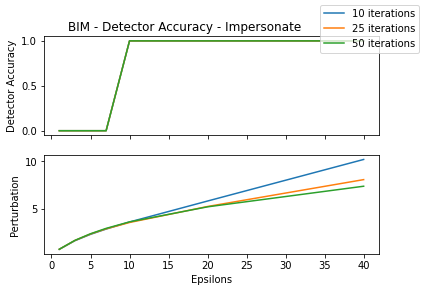

In [14]:
FILENAME = 'bim_0to1_det_ext.csv'

bim_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_title("BIM - Detector Accuracy - Impersonate              ")

for max_iter in ITERS:
  cut_bim_0to1 = bim_0to1[bim_0to1['max_iter'] == max_iter]

  epsilon = cut_bim_0to1['epsilon'].tolist()
  mean_perturbation = cut_bim_0to1['mean_perturbation'].tolist()
  detection_accuracy = cut_bim_0to1['detection_accuracy'].tolist()

  ax[0].plot(epsilon, detection_accuracy, label=f'{max_iter} iterations')
  ax[1].plot(epsilon, mean_perturbation)

  ax[1].set_xlabel("Epsilons")
  ax[1].set_ylabel("Perturbation")
  ax[0].set_ylabel("Detector Accuracy")

fig.legend()


### PGD

#### Do not recognize

In [22]:
EPSILONS = [1, 3, 5, 7, 10, 20, 40] 
ITERS = [10, 25, 50]

In [ ]:
FILENAME = 'pgd_1to0_det_ext.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  pgd_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  pgd_1to0 = pd.DataFrame(columns=['epsilon', 'epsilon_step', 'max_iter', 'mean_perturbation', 'detection_accuracy'])

y_test = np.array([1] * test_imgs_1.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
  for max_iter in tqdm(ITERS, leave=False, desc='max iter'):
    epsilon_step = epsilon / max_iter

    # Generate the adversarial image
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False, verbose=False)
    images_adv = attack.generate(test_imgs_1)

    # Save perturbations
    perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_1[i])) for i in range(len(images_adv))]

    # Generate the embeddings
    embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

    # Predict on the MLP (and SVM for trasfering)
    y_pred = np.rint(dmodel.predict(embeddings))
    y_test = np.array([1] * len(y_pred))

    pgd_1to0 = pgd_1to0.append(dict(epsilon=epsilon,
                                    epsilon_step=epsilon_step,
                                    max_iter=max_iter,
                                    mean_perturbation=statistics.mean(perturbations), 
                                    detection_accuracy=metrics.accuracy_score(y_test, y_pred)),
                              ignore_index=True)

    pgd_1to0.to_csv(os.path.join('.', 'attack', FILENAME), index=False)


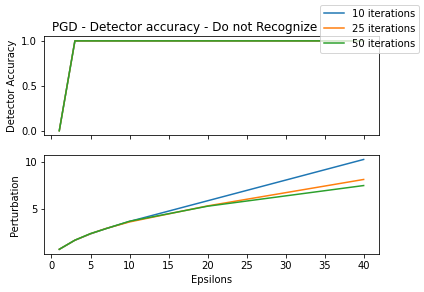

In [23]:
FILENAME = 'pgd_1to0_det_ext.csv'

pgd_1to0 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_title("PGD - Detector accuracy - Do not Recognize              ")

for max_iter in ITERS:
  cut_pgd_1to0 = pgd_1to0[pgd_1to0['max_iter'] == max_iter]

  epsilon = cut_pgd_1to0['epsilon'].tolist()
  mean_perturbation = cut_pgd_1to0['mean_perturbation'].tolist()
  detection_accuracy = cut_pgd_1to0['detection_accuracy'].tolist()

  ax[0].plot(epsilon, detection_accuracy, label=f'{max_iter} iterations')
  ax[1].plot(epsilon, mean_perturbation)

  ax[1].set_xlabel("Epsilons")
  ax[1].set_ylabel("Perturbation")
  ax[0].set_ylabel("Detector Accuracy")

fig.legend()


#### Impersonate

In [20]:
EPSILONS = [1, 3, 5, 7, 10, 20, 40] 
ITERS = [10, 25, 50]


In [ ]:
FILENAME = 'pgd_0to1_det_ext.csv'

if os.path.exists(os.path.join('.', 'attack', FILENAME)):
  pgd_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)
else:
  pgd_0to1 = pd.DataFrame(columns=['epsilon', 'epsilon_step', 'max_iter', 'mean_perturbation', 'detection_accuracy'])

y_test = np.array([0] * test_imgs_0.shape[0])

for epsilon in tqdm(EPSILONS, leave=True, desc='epsilons'):
  for max_iter in tqdm(ITERS, leave=False, desc='max iter'):
    epsilon_step = epsilon / max_iter

    # Generate the adversarial image
    attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False, verbose=False)
    images_adv = attack.generate(test_imgs_0)

    # Save perturbations
    perturbations = [np.mean(np.abs(images_adv[i] - test_imgs_0[i])) for i in range(len(images_adv))]

    # Generate the embeddings
    embeddings = [preprocesser.process(images_adv[i].astype('uint8'), embedd=True, process_type='preprocess') for i in tqdm(range(len(images_adv)), desc='embedding', leave=False)]

    # Predict on the MLP (and SVM for trasfering)
    y_pred = np.rint(dmodel.predict(embeddings))
    y_test = np.array([1] * len(y_pred))

    pgd_0to1 = pgd_0to1.append(dict(epsilon=epsilon,
                                    epsilon_step=epsilon_step,
                                    max_iter=max_iter,
                                    mean_perturbation=statistics.mean(perturbations), 
                                    detection_accuracy=metrics.accuracy_score(y_test, y_pred)),
                               ignore_index=True)

    pgd_0to1.to_csv(os.path.join('.', 'attack', FILENAME), index=False)
  

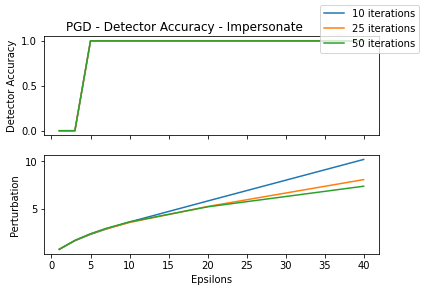

In [21]:
FILENAME = 'pgd_0to1_det_ext.csv'

pgd_0to1 = pd.read_csv(os.path.join('.', 'attack', FILENAME), index_col=None)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_title("PGD - Detector Accuracy - Impersonate              ")

for max_iter in ITERS:
  cut_pgd_0to1 = pgd_0to1[pgd_0to1['max_iter'] == max_iter]

  epsilon = cut_pgd_0to1['epsilon'].tolist()
  mean_perturbation = cut_pgd_0to1['mean_perturbation'].tolist()
  detection_accuracy = cut_pgd_0to1['detection_accuracy'].tolist()

  ax[0].plot(epsilon, detection_accuracy, label=f'{max_iter} iterations')
  ax[1].plot(epsilon, mean_perturbation)

  ax[1].set_xlabel("Epsilons")
  ax[1].set_ylabel("Perturbation")
  ax[0].set_ylabel("Detector Accuracy")

fig.legend()
